# Import librarys

In [1]:
from keras.models import load_model
from keras.metrics import MeanSquaredError
from sklearn.base import BaseEstimator
from keras.models import Model
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
import keras
from keras.callbacks import History
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
import keras
from scikeras.wrappers import KerasRegressor
from keras.layers import Input
from keras.optimizers import RMSprop
import yfinance as yf
from matplotlib.backends.backend_pdf import PdfPages
import pickle

# CSV einlesen

In [2]:
def download_stock_data(stock_symbols, start_date, end_date, output_file):
    with open(output_file, 'w') as f:
        # Write column headings
        f.write('Date,Open,High,Low,Close,Volume\n')
        
        for symbol in stock_symbols:
            # Load the share data for every symbol and the defined time period
            stock_data = yf.download(symbol, start=start_date, end=end_date)
            stock_data = stock_data[['Open', 'High', 'Low', 'Close', 'Volume']]  # Auswahl der gewünschten Spalten
            stock_data.to_csv(f, header=False)  # Schreiben der Daten in die Datei


In [3]:
# Define time period and symbol
stock_symbols = ['RWE.DE']
start_date = '2000-01-01'
end_date = '2023-12-31'
output_file = 'stock_data.csv'

# Load and store the share data
download_stock_data(stock_symbols, start_date, end_date, output_file)

# Search and delete empty rows in the CSV file
with open(output_file, 'r') as file:
    lines = file.readlines()

# Filter empty rows
lines = [line.strip() for line in lines if line.strip()]

# Overwrite the file with the cleaned rows
with open(output_file, 'w') as file:
    file.write('\n'.join(lines))

[*********************100%%**********************]  1 of 1 completed


In [4]:
# load CSV
df = pd.read_csv('stock_data.csv')

# transform date to index
df.set_index('Date', inplace=True)

# Show first rows
print(df.head())
print(len(df))

                 Open       High        Low      Close   Volume
Date                                                           
2000-01-03  39.568237  40.066578  38.422054  38.671223  1236054
2000-01-04  38.970230  38.970230  36.986832  38.681190  1448199
2000-01-05  36.857265  38.521721  36.378857  37.415405  1475345
2000-01-06  37.375538  38.372219  37.186169  38.162918   935343
2000-01-07  38.471889  38.870560  37.176205  37.365574  1538811
6137


In [5]:
# Check, if there are any missing numbers
missing_values_before = df.isnull().values.any()

# Treat missing values with the mean of the previous and the following row
for column in df.columns:
    missing_values = df[column].isnull()
    df.loc[missing_values, column] = (df[column].shift() + df[column].shift(-1)) / 2

# Check, if there are missing values after the Treatment
missing_values_after = df.isnull().values.any()

# Output of the missing values before and after the Treatment
print("Fehlende Werte vor der Behandlung gefunden:", missing_values_before)
print("Fehlende Werte nach der Behandlung gefunden:", missing_values_after)

Fehlende Werte vor der Behandlung gefunden: False
Fehlende Werte nach der Behandlung gefunden: False


In [6]:
# show first rows
print(df.head())

                 Open       High        Low      Close   Volume
Date                                                           
2000-01-03  39.568237  40.066578  38.422054  38.671223  1236054
2000-01-04  38.970230  38.970230  36.986832  38.681190  1448199
2000-01-05  36.857265  38.521721  36.378857  37.415405  1475345
2000-01-06  37.375538  38.372219  37.186169  38.162918   935343
2000-01-07  38.471889  38.870560  37.176205  37.365574  1538811


# Data normalization

In [7]:
# Copy the data frame and remove the column "date"
nf = df.copy()

# Remove the index name
nf.index.name = None

# Normalize the data, except the "date" (index)
scaler = MinMaxScaler()
nf_normalized = scaler.fit_transform(nf)

# Create a new data frame with the normalized data and the original index
nf = pd.DataFrame(nf_normalized, columns=nf.columns, index=nf.index)

# Show the normalized data
print(nf.head())

# Show the length of the data frame
print("Länge des Datensatzes:", len(nf))

                Open      High       Low     Close    Volume
2000-01-03  0.334060  0.327197  0.328187  0.323453  0.029513
2000-01-04  0.327495  0.315326  0.312109  0.323563  0.034579
2000-01-05  0.304302  0.310469  0.305298  0.309668  0.035227
2000-01-06  0.309991  0.308850  0.314342  0.317874  0.022333
2000-01-07  0.322025  0.314246  0.314230  0.309121  0.036742
Länge des Datensatzes: 6137


In [8]:
# save scaler
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

# read predicting sequence

In [9]:
# Define time period and output file
start_date = '2019-10-01'
end_date = '2019-12-31'
output_file = 'stock_data_pre.csv'

# Load and store the share data
download_stock_data(stock_symbols, start_date, end_date, output_file)

# Search and delete the empty rows in the CSV file
with open(output_file, 'r') as file:
    lines = file.readlines()

# Filter the empty rows
lines = [line.strip() for line in lines if line.strip()]

# Overwrite the file with the cleaned rows
with open(output_file, 'w') as file:
    file.write('\n'.join(lines))

[*********************100%%**********************]  1 of 1 completed


In [10]:
# load CSV
dfPre = pd.read_csv('stock_data_pre.csv')

# Drop empty rows
dfPre.dropna(inplace=True)

# transform date to index
dfPre.set_index('Date', inplace=True)

# Check the number of rows
num_rows = dfPre.shape[0]

# If more than 60 rows, keep the last 60 rows
if num_rows > 60:
    dfPre = dfPre.tail(60)

# Show first rows
print(dfPre.head())

                 Open       High        Low      Close   Volume
Date                                                           
2023-10-05  33.000000  33.189999  32.869999  33.040001  1641405
2023-10-06  33.040001  33.099998  31.549999  32.730000  2679175
2023-10-09  32.900002  33.349998  32.799999  33.090000  1903629
2023-10-10  33.549999  34.480000  33.549999  34.270000  2932864
2023-10-11  34.389999  35.049999  34.230000  34.630001  2509883


In [11]:
# Check, if there are missing values before the treatment
missing_values_beforePre = dfPre.isnull().values.any()

# Treat missing values for all columns with the mean of the previous and following row
for column in df.columns:
    missing_valuesPre = dfPre[column].isnull()
    dfPre.loc[missing_valuesPre, column] = (dfPre[column].shift() + dfPre[column].shift(-1)) / 2

# Check, if there are missing values after the treatment
missing_values_afterPre = dfPre.isnull().values.any()

# Output of the missing values before and after the treatment
print("Fehlende Werte vor der Behandlung gefunden:", missing_values_beforePre)
print("Fehlende Werte nach der Behandlung gefunden:", missing_values_afterPre)

# show lenth of data set
print(len(dfPre))

Fehlende Werte vor der Behandlung gefunden: False
Fehlende Werte nach der Behandlung gefunden: False
60


# Data normalization prediction data

In [12]:
# Copy the data frame and remove the column "date"
nfPre = dfPre.copy()

# Remove the index name
nfPre.index.name = None

# Normalize the data, except the "date" (Index)
nfPre_normalized = scaler.fit_transform(nfPre)

# Create a data frame with the normalized data and the original index
nfPre = pd.DataFrame(nfPre_normalized, columns=nfPre.columns, index=nfPre.index)

# Convert DataFrame to NumPy array
nfPre = nfPre.to_numpy()

# Show length of the data frame
print("Länge des Datensatzes:", len(nfPre))


Länge des Datensatzes: 60


# Create Sequences

In [13]:
# Function to create sequenences for LSTM model
def create_sequences(data_input, seq_length):
    data = data_input
    X, y = [], []
    for i in range(len(data) - seq_length - 20):
        X.append(data[i:i+seq_length])
        y.append(data.iloc[i+seq_length+20]) # acess to Close-Value of the 20th row
    return np.array(X), np.array(y)

In [14]:
# create sequence
sequence_length = 60
X, y = create_sequences(nf, sequence_length)

# Split the data in Training, Test and validation

In [15]:
# Split data in training and test (80% training, 20% test)
train_data, test_data = train_test_split(nf, test_size=0.2, shuffle=False)

# Split data in training and validation (80% training, 20% validation)
train_data, val_data = train_test_split(train_data, test_size=0.2, shuffle=False)

# Split the train data in sequences
X_train, y_train = create_sequences(train_data, sequence_length)

# Split the validation data in sequences
X_val, y_val = create_sequences(val_data, sequence_length)

# Split the test data in sequences
X_test, y_test = create_sequences(test_data, sequence_length)

# show training, validation and test sets
print("Trainingsdaten:", len(train_data))
print("Validierungsdaten:", len(val_data))
print("Testdaten:", len(test_data))

Trainingsdaten: 3927
Validierungsdaten: 982
Testdaten: 1228


In [16]:
# Define train_size, val_size and test_size
train_size = len(train_data)
val_size = len(val_data)
test_size = len(test_data)
nfPre_size = len(nfPre)

# Extract features and target variables for training, validation, and test sets
X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:train_size+val_size], y[train_size:train_size+val_size]
X_test, y_test = X[train_size+val_size:], y[train_size+val_size:]
# Add a external dimension
X_pre = np.expand_dims(nfPre[:nfPre_size], axis=0)


In [17]:
# Convert the train, val and prediction data into tensors
X_train_tensor = tf.convert_to_tensor(X_train, dtype=tf.float32)
y_train_tensor = tf.convert_to_tensor(y_train, dtype=tf.float32)
X_val_tensor = tf.convert_to_tensor(X_val, dtype=tf.float32)
y_val_tensor = tf.convert_to_tensor(y_val, dtype=tf.float32)
X_pre_tensor = tf.convert_to_tensor(X_pre, dtype=tf.float32)

# Define model

In [18]:
# Define the hyper parameters
units = 25
learning_rate = 0.003
optimizer = Adam(learning_rate=learning_rate)
dropout_rate = 0.5
batch_size = 128
epochs = 10

In [19]:
# Define input layer
input_layer = Input(shape=(sequence_length, 5))

# create model
model = Sequential([
    LSTM(units=units, return_sequences=True),
    Dropout(dropout_rate),
    LSTM(units=units, return_sequences=False),
    Dropout(dropout_rate),
    Dense(units=5)  # Anpassen der Anzahl der Ausgabeneinheiten auf 5 für 5 Input-Variablen
])

# Compile the model
model.compile(optimizer=optimizer, loss='mean_squared_error')

# Evaluate model

Epoch 1/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.0730 - val_loss: 0.0032
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0189 - val_loss: 0.0019
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0127 - val_loss: 0.0020
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0099 - val_loss: 0.0022
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0088 - val_loss: 0.0021
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0075 - val_loss: 0.0018
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0062 - val_loss: 0.0018
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0059 - val_loss: 0.0019
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0056 - val_loss: 0.0019
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0051 - val_loss: 0.0021


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 25)         │         3,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 25)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 25)             │         5,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 25)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 5)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,992 (97.63 KB)

 Trainable params: 8,330 (32.54 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 16,662 (65.09 KB)

None


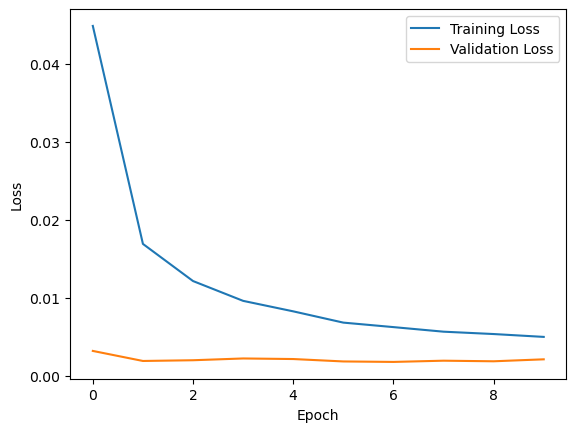

In [20]:
# Retrieve the history object
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, y_val))

# Show the model summary
print(model.summary())

# Plot the loss function during the training
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Modell speichern

In [21]:
for symbol in stock_symbols:
    model.save(f'Predict20Days2024_{symbol}.h5.keras')

# Predictions X-test

In [22]:
predictions = model.predict(X_test)
print(f'Prediction: {predictions}')
print(len(predictions))
print(len(X_test))

36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
Prediction: [[0.1719428  0.16460979 0.16821666 0.16317281 0.06787471]
 [0.17141703 0.16418526 0.16756824 0.16252533 0.0678345 ]
 [0.17048085 0.1633314  0.16653275 0.16149339 0.06779213]
 ...
 [0.31277686 0.3098476  0.31575438 0.31458795 0.06609774]
 [0.31436464 0.31160715 0.31735522 0.3161533  0.06608557]
 [0.3147624  0.31203517 0.31771356 0.3166135  0.06610236]]
1148
1148


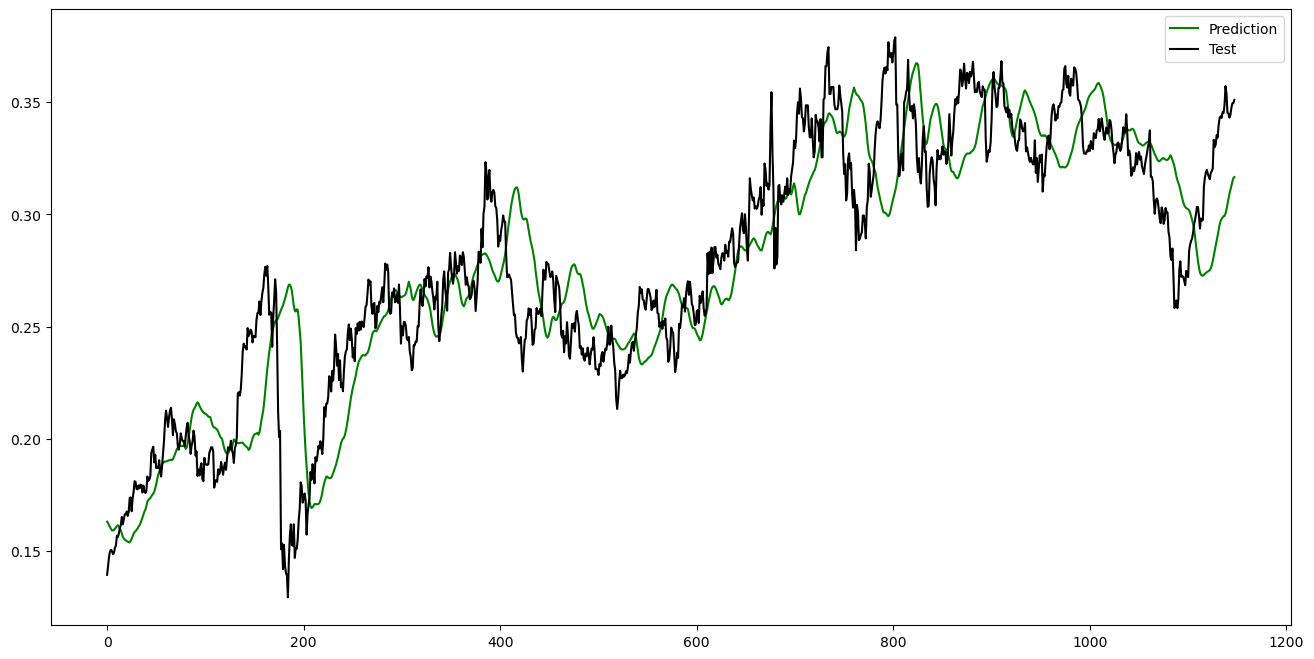

In [23]:
plt.figure(figsize=(16, 8))
plt.plot(predictions[:,-2], color="green", label="Prediction")
plt.plot(y_test[:,-2], color="black", label="Test")
plt.legend()
plt.show()

# Prediction for the unkonown sequence

In [24]:
predictions = model.predict(X_pre)
prediction_20_days_ahead = predictions[0][-2]
print(f'Prediction: {predictions}')
print(len(predictions))
print(len(X_pre))
print(prediction_20_days_ahead)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Prediction: [[0.8188134  0.8227795  0.833066   0.82738423 0.08346088]]
1
1
0.82738423


# Transform back into monetary values

In [25]:
# Inverse transformation of the predictions
predictions_original_scale = scaler.inverse_transform(predictions)
print(predictions_original_scale)
prediction_20_days_ahead = predictions_original_scale[0][-2]

# shape a 1-Dimensional array
predictions_close = predictions_original_scale[:, -1]  # Extract only the close values

# Show values of inverse transformation
print("Zurücktransformierte Vorhersagen:")
print(predictions_original_scale)
print(prediction_20_days_ahead)

[[4.0351204e+01 4.0694256e+01 3.9997288e+01 4.0184734e+01 1.0647124e+06]]
Zurücktransformierte Vorhersagen:
[[4.0351204e+01 4.0694256e+01 3.9997288e+01 4.0184734e+01 1.0647124e+06]]
40.184734


# read test CSV from 2019

In [26]:
# Define time period and output file
start_date = '2019-01-01'
end_date = '2019-01-31'
output_file = 'stock_data_2019.csv'

# Load and store the share data
download_stock_data(stock_symbols, start_date, end_date, output_file)

# Search and delete empty rows in the CSV file
with open(output_file, 'r') as file:
    lines = file.readlines()

# Filter empty rows
lines = [line.strip() for line in lines if line.strip()]

# Overwrite the file with the cleaned data
with open(output_file, 'w') as file:
    file.write('\n'.join(lines))

[*********************100%%**********************]  1 of 1 completed


In [27]:
# no normalization. The data will be compared to the prediction data from the LSTM
# load CSV
df2019 = pd.read_csv('stock_data_2019.csv')

# transform date to index
df2019.set_index('Date', inplace=True)

print(df2019.head())

# Select columns "Date" and "Close"
selected_columns = ['Open', 'High', 'Low', 'Close', 'Volume']
df2019 = df2019[selected_columns]

# Show first rows
print(df2019.head())

                 Open       High        Low      Close   Volume
Date                                                           
2019-01-02  18.885000  19.375000  18.745001  19.299999  4291989
2019-01-03  19.180000  19.709999  19.020000  19.525000  3622844
2019-01-04  19.690001  20.080000  19.559999  19.924999  3288528
2019-01-07  19.990000  20.059999  19.705000  19.900000  3042945
2019-01-08  19.900000  20.080000  19.820000  19.980000  2658621
                 Open       High        Low      Close   Volume
Date                                                           
2019-01-02  18.885000  19.375000  18.745001  19.299999  4291989
2019-01-03  19.180000  19.709999  19.020000  19.525000  3622844
2019-01-04  19.690001  20.080000  19.559999  19.924999  3288528
2019-01-07  19.990000  20.059999  19.705000  19.900000  3042945
2019-01-08  19.900000  20.080000  19.820000  19.980000  2658621


# Compare predictions to actual share values

In [28]:
# Extract the last row
last_row = df2019.iloc[-1]
# extract the "Close" value of the last row
actual_close = last_row['Close']
# Create a DataFrame with only one entry for the actual closing price and on entry for the predicted closing price
comparison_df = pd.DataFrame({'Actual': [actual_close], 'Predicted': prediction_20_days_ahead}, index=[last_row.name])
# Show comparison
print(comparison_df)


               Actual  Predicted
2019-01-30  21.530001  40.184734
